In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
import seaborn as sns
from sklearn.model_selection import cross_val_score

## Given:
### [Real or Fake] : Fake Job Description Prediction
### This dataset contains 18K job descriptions out of which about 800 are fake. The data consists of both textual information and meta-information about the jobs. The dataset can be used to create classification models which can learn the job descriptions which are fraudulent.

## Goal:
### 1. Create a classification model that uses text data features and meta-features and predict which job description are fraudulent or real.

## Load and Analyze the data:

In [2]:
df = pd.read_csv("../data/raw/fake_job_postings.csv", index_col=0)
df.head()

,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
job_id,,,,,,,,,,,,,,,,,
1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17880 entries, 1 to 17880
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   title                17880 non-null  object
 1   location             17534 non-null  object
 2   department           6333 non-null   object
 3   salary_range         2868 non-null   object
 4   company_profile      14572 non-null  object
 5   description          17879 non-null  object
 6   requirements         15184 non-null  object
 7   benefits             10668 non-null  object
 8   telecommuting        17880 non-null  int64 
 9   has_company_logo     17880 non-null  int64 
 10  has_questions        17880 non-null  int64 
 11  employment_type      14409 non-null  object
 12  required_experience  10830 non-null  object
 13  required_education   9775 non-null   object
 14  industry             12977 non-null  object
 15  function             11425 non-null  object
 16  fraudulen

In [4]:
df.isna().sum().sort_values()

title                      0
has_questions              0
has_company_logo           0
telecommuting              0
fraudulent                 0
description                1
location                 346
requirements            2696
company_profile         3308
employment_type         3471
industry                4903
function                6455
required_experience     7050
benefits                7212
required_education      8105
department             11547
salary_range           15012
dtype: int64

In [5]:
df.shape

(17880, 17)

In [6]:
# Count the occurrences of 0 and 1 in the 'fraudulent' column
fraudulent_counts = df['fraudulent'].value_counts()
fraudulent_counts

fraudulent
0    17014
1      866
Name: count, dtype: int64

<Axes: xlabel='fraudulent', ylabel='count'>

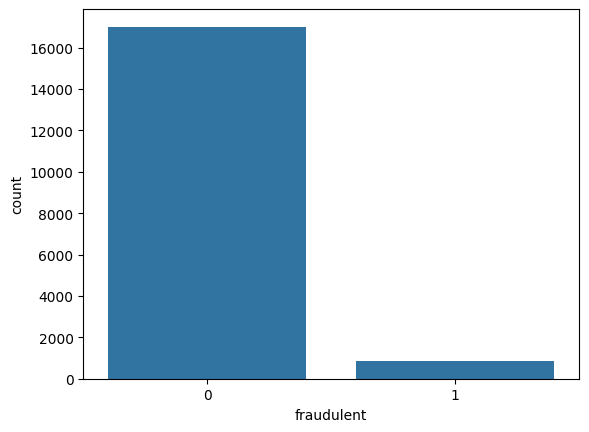

In [7]:
sns.countplot(x = "fraudulent" , data = df)

## Select features:


In [8]:
description_df = df.copy()
description_df = description_df[['description','fraudulent']]

# Checking for null values and empty strings

print(f"{description_df.isna().sum()} null values")
print(f"{(description_df == '').sum()} empty strings")
print(description_df.shape)

description    1
fraudulent     0
dtype: int64 null values
description    0
fraudulent     0
dtype: int64 empty strings
(17880, 2)


In [9]:
#removing null values

description_df.dropna(subset=['description'], inplace=True)
print(f"{description_df.isna().sum()} null values")


description    0
fraudulent     0
dtype: int64 null values


## Spliting the data into training and testing sets

In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    description_df['description'],
    description_df['fraudulent'],
    random_state=42)



print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(13409,)
(13409,)
(4470,)
(4470,)


## Converting text data into TF-IDF features

In [11]:
# TF-IDF transformer is fitted only on the training data

vectorizer = TfidfVectorizer(stop_words='english', min_df=5, max_df=0.8, ngram_range=(1,2))
vectorizer.fit(X_train)

# Transform the text data into TF-IDF vectors
X_train = vectorizer.transform(X_train)
X_test = vectorizer.transform(X_test)

# When i try to add another feature i get (2,2) shape
# one way to get around this is by combining all of the string features in one column and then vectorize them


In [12]:
print(X_train.shape)
print(X_test.shape)

(13409, 63746)
(4470, 63746)


In [13]:
y_train_counts = y_train.value_counts()

In [14]:
# check for imbalaced dataset - calculate percentages:
percentages = (y_train_counts/y_train_counts.sum())*100
percentages

fraudulent
0    95.159967
1     4.840033
Name: count, dtype: float64

## Oversampling because the dataset is imbalanced

In [15]:
# Creating an instance of SMOTE
smote = SMOTE()

# Balancing the data
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

print(X_resampled.shape)
print(y_resampled.shape)

(25520, 63746)
(25520,)


In [16]:
# check for imbalaced dataset - calculate percentages:
y_resampled_counts = y_resampled.value_counts()
percentages = (y_resampled_counts/y_resampled_counts.sum())*100
percentages

fraudulent
0    50.0
1    50.0
Name: count, dtype: float64

## Train the model with GridSearchCV

In [17]:
parameters = {'alpha': [0.1, 0.5, 1.0, 1.5, 2.0]}
model = MultinomialNB()
clf = GridSearchCV(model, parameters,cv=10, n_jobs=-1)
clf.fit(X_resampled, y_resampled)

GridSearchCV(cv=10, estimator=MultinomialNB(), n_jobs=-1,
             param_grid={'alpha': [0.1, 0.5, 1.0, 1.5, 2.0]})

In [18]:
print(clf.best_params_)
print(clf.best_score_)

{'alpha': 0.1}
0.9884796238244513


## Test and evaluation

In [19]:
train_accuracy = clf.score(X_resampled, y_resampled)
test_accuracy = clf.score(X_test, y_test)
print(f"Training Accuracy: {train_accuracy}")
print(f"Test Accuracy: {test_accuracy}")

Training Accuracy: 0.990909090909091
Test Accuracy: 0.9711409395973154


In [20]:
# Make predictions on the test set
y_pred = clf.predict(X_test)

In [21]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)       # Calculate the accuracy
report = classification_report(y_test, y_pred)  # Get the precision, recall, f1-score

print(f'Accuracy: {accuracy:.2f}')
print('Classification Report:')
print(report)

Accuracy: 0.97
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.98      4254
           1       0.70      0.71      0.70       216

    accuracy                           0.97      4470
   macro avg       0.84      0.85      0.84      4470
weighted avg       0.97      0.97      0.97      4470



In [22]:
# Display the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred, labels=[0, 1])
print(conf_matrix)

[[4188   66]
 [  63  153]]


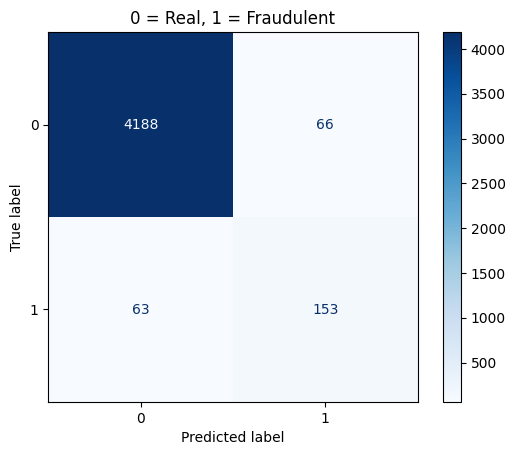

In [23]:
# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(cmap=plt.cm.Blues)
plt.grid(False)
plt.title("0 = Real, 1 = Fraudulent")
plt.show()